# Assignment: Exploratory Data Analysis
### `! git clone https://github.com/DS3001/visualization`
### Do Q1 or Q2 or Q3, and Q4. You might want to refer to your work for the data wrangling assignment.

**Q2.** This question uses the Airbnb data to practice making visualizations.

  1. Load the `./data/airbnb_hw.csv` data with Pandas. You should have cleaned the `Price` variable in question 2, and you'll need it later for this question.
  2. What are are the dimensions of the data? How many observations are there? What are the variables included? Use `.head()` to examine the first few rows of data.
  3. Cross tabulate `Room Type` and `Property Type`. What patterns do you see in what kinds of rentals are available? For which kinds of properties are private rooms more common than renting the entire property?
  4. For `Price`, make a histogram, kernel density, box plot, and a statistical description of the variable. Are the data badly scaled? Are there many outliers? Use `log` to transform price into a new variable, `price_log`, and take these steps again.
  5. Make a scatterplot of `price_log` and `Beds`. Describe what you see. Use `.groupby()` to compute a desciption of `Price` conditional on/grouped by the number of beds. Describe any patterns you see in the average price and standard deviation in prices.
  6. Make a scatterplot of `price_log` and `Beds`, but color the graph by `Room Type` and `Property Type`. What patterns do you see? Compute a description of `Price` conditional on `Room Type` and `Property Type`. Which Room Type and Property Type have the highest prices on average? Which have the highest standard deviation? Does the mean or median appear to be a more reliable estimate of central tendency, and explain why?
  7. We've looked a bit at this `price_log` and `Beds` scatterplot. Use seaborn to make a `jointplot` with `kind=hex`. Where are the data actually distributed? How does it affect the way you think about the plots in 5 and 6?

In [1]:
# necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# q2.1 #

# need to clean Price bc vals > 999 have commas and wont be handled right
# reviewed wrangling hw #
df = pd.read_csv('./data/airbnb_hw.csv')

temp = df['Price']
temp = temp.str.replace(',','') # removes commas
temp = pd.to_numeric(temp,errors='coerce') # convert to numeric val

df['Price'] = temp
del temp

In [3]:
# q2.2 #

print(df.shape)
# df.columns

df.head()

# there's 30478 observations with 13 diff vars; these are the diff vars: ['Host Id', 'Host Since', 'Name', 'Neighbourhood ',
    # 'Property Type','Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds', 'Number of Records', 'Number Of Reviews', 
    # 'Price', 'Review Scores Rating'] (found from df.columns)

(30478, 13)


,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [4]:
# q2.3 #

pd.crosstab(df['Property Type'],df['Room Type'])

# the most common rental types are Apartments, Houses, Lofts, and then Townhouses/Condos.
# for a majority of the rental types, it's the entire property that's being rented, but for houses, there's
# more rentals offered for a private room, similar for Bed & Breakfasts and Dorms.

Room Type,Entire home/apt,Private room,Shared room
Property Type,,,
Apartment,15669,10748,685
Bed & Breakfast,13,155,12
Boat,7,1,0
Bungalow,4,0,0
Cabin,1,1,0
Camper/RV,6,1,0
Castle,0,1,0
Chalet,0,1,0
Condominium,72,22,0


<Axes: xlabel='Price', ylabel='Count'>

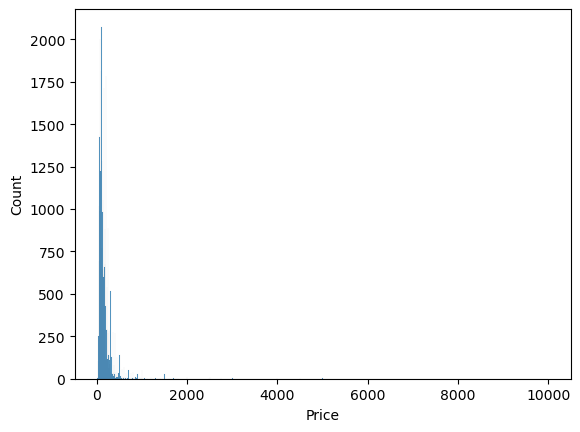

In [5]:
# q2.4 #

sns.histplot(data = df, x = 'Price')

<Axes: xlabel='Price', ylabel='Density'>

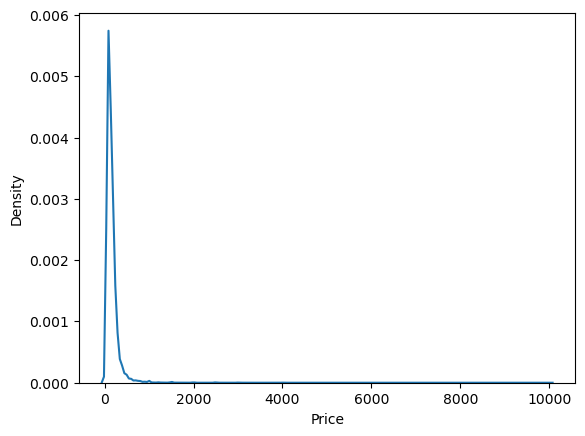

In [6]:
sns.kdeplot(data = df, x = 'Price')

<Axes: xlabel='Price'>

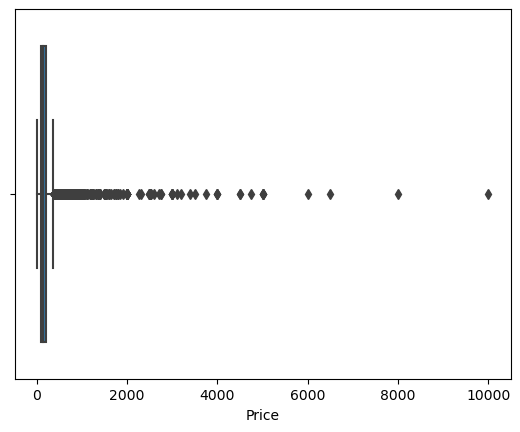

In [7]:
sns.boxplot(data = df, x = 'Price')

In [8]:
df['Price'].describe()

count    30478.000000
mean       163.589737
std        197.785454
min         10.000000
25%         80.000000
50%        125.000000
75%        195.000000
max      10000.000000
Name: Price, dtype: float64

with the default graph settings, the data is scaled poorly – the x-axis ranges from 0 to 10000 when really most of the data lies far outside of the upper range, closer to 1000, thus making the plots look so narrow and skewed left.

<Axes: xlabel='price_log', ylabel='Count'>

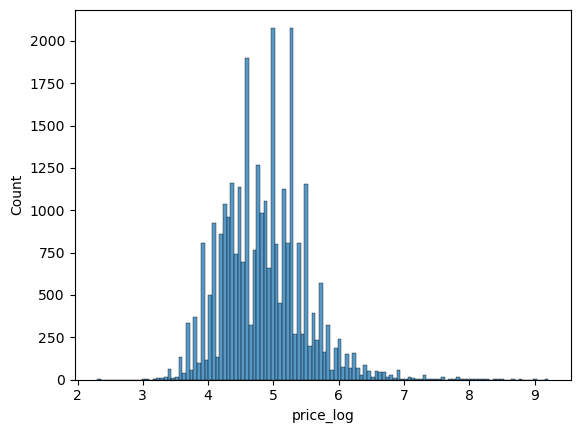

In [9]:
# still q2.4 but now with logs

df['price_log'] = np.log(df['Price'])
sns.histplot(data = df, x = 'price_log')

<Axes: xlabel='price_log', ylabel='Density'>

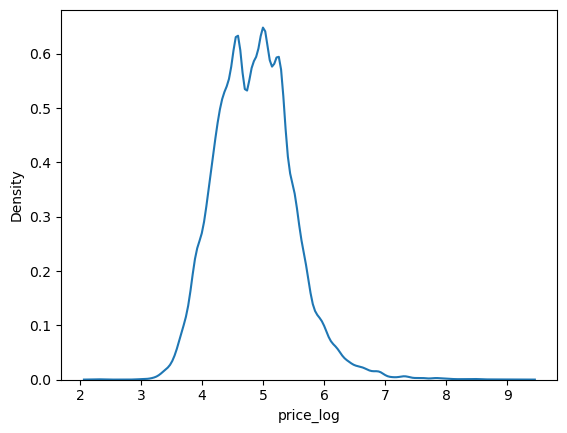

In [10]:
sns.kdeplot(data = df, x = 'price_log')

<Axes: xlabel='price_log'>

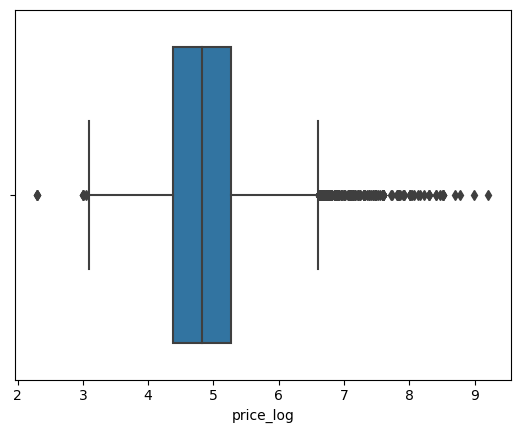

In [11]:
sns.boxplot(data = df, x = 'price_log')

In [12]:
df['price_log'].describe()

count    30478.000000
mean         4.860495
std          0.627704
min          2.302585
25%          4.382027
50%          4.828314
75%          5.273000
max          9.210340
Name: price_log, dtype: float64

in using the log of the price data, the new plots look much more evenly distributed where you can actually see the cope of all the data instead of small slivers of information skewed to the very left of the entire plot – now there's a more full coverage of the entire plot space, showing more clearly how the data is presented in the respective graphs. there aren't really any outliers, all the data pretty much gathers towards the peaks/avgs of all the data.

Price                                                           \
        count         mean          std    min     25%    50%      75%   
Beds                                                                     
0.0       2.0    92.000000    38.183766   65.0   78.50   92.0   105.50   
1.0   20344.0   127.673810   107.047827   10.0   75.00  100.0   155.00   
2.0    6610.0   199.061271   225.706318   25.0  115.00  160.0   225.00   
3.0    2071.0   268.118300   303.106942   26.0  140.00  200.0   300.00   
4.0     783.0   315.332056   353.184402   27.0  150.00  247.0   375.00   
5.0     284.0   411.500000   672.610659   35.0  189.75  290.0   450.00   
6.0     177.0   401.768362   417.018431   35.0  199.00  275.0   425.00   
7.0      45.0   341.377778   220.116631   55.0  177.00  300.0   445.00   
8.0      24.0   589.041667   793.054934   55.0  243.75  350.0   481.25   
9.0      15.0   618.000000   233.649616  175.0  447.50  650.0   762.50   
10.0     16.0   480.187500   296.820534   95.0  291.00  407.5   706.25   
11.0      5.0   535.800000   499.217588  100.0  220.00  359.0   650.00   
12.0      4.0  1418.750000  2388.285211  150.0  206.25  262.5  1475.00   
16.0     13.0   736.000000   496.804287  104.0  350.00  625.0  1000.00   

               
          max  
Beds           
0.0     119.0  
1.0    4000.0  
2.0   10000.0  
3.0    5000.0  
4.0    6500.0  
5.0    8000.0  
6.0    2750.0  
7.0     900.0  
8.0    4000.0  
9.0    1050.0  
10.0   1050.0  
11.0   1350.0  
12.0   5000.0  
16.0   1500.0

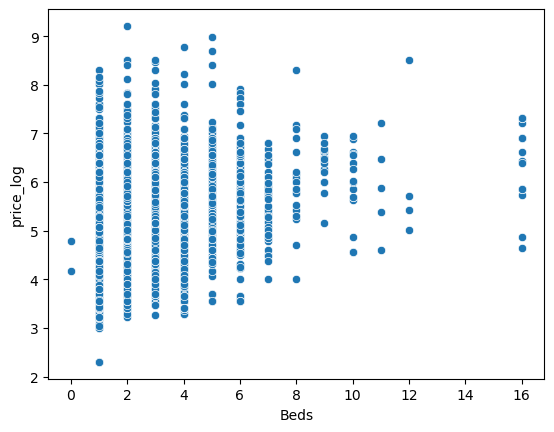

In [13]:
# q2.5 #

sns.scatterplot(data = df, x = 'Beds', y = 'price_log')
df.loc[:,['Beds','Price']].groupby('Beds').describe()

# a majority of ppl rent out one bed – the trend is that as amount of beds increases, the number of people renting that number
# of beds decreases. additionally, as # of beds increases, price also goes up. with the scatterplot, there does seem to be
# more apparent the outliers, especially higher end outliers. also, around the 6 bed mark seems to be where the std flutters
# down, which supports the histogram having peak around the 4-6 range where the data increases and then decreases

Price                                                     \
                   count        mean         std   min    25%    50%    75%   
Room Type                                                                     
Entire home/apt  17024.0  220.796346  242.222346  10.0  135.0  175.0  240.0   
Private room     12609.0   91.919740   67.119678  10.0   65.0   80.0  100.0   
Shared room        845.0   80.514793  110.756196  10.0   45.0   60.0   85.0   

                          
                     max  
Room Type                 
Entire home/apt  10000.0  
Private room      3000.0  
Shared room       2500.0

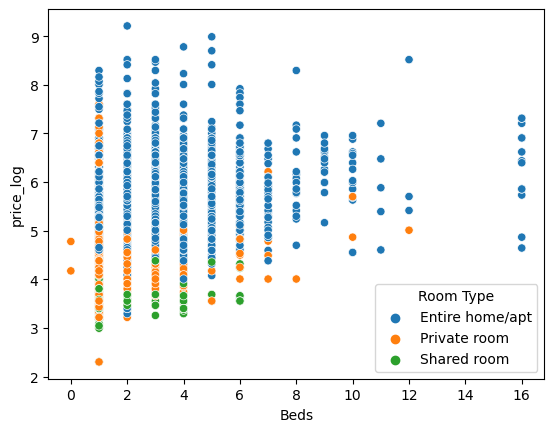

In [14]:
# q2.6 #

sns.scatterplot(data = df, x = 'Beds', y = 'price_log', hue = 'Room Type')
df.loc[:,['Room Type','Price']].groupby('Room Type').describe()

Price                                                \
                   count        mean         std    min     25%    50%   
Property Type                                                            
Apartment        27102.0  162.045642  181.376882   10.0   85.00  130.0   
Bed & Breakfast    180.0  106.572222   84.701977   30.0   65.00   87.5   
Boat                 8.0  153.625000   49.231051  100.0  120.00  137.5   
Bungalow             4.0  150.750000   46.464144   87.0  133.50  160.5   
Cabin                2.0  165.000000  120.208153   80.0  122.50  165.0   
Camper/RV            7.0  103.571429  102.343958   39.0   47.00   49.0   
Castle               1.0  150.000000         NaN  150.0  150.00  150.0   
Chalet               1.0   99.000000         NaN   99.0   99.00   99.0   
Condominium         94.0  256.585106  249.357946   46.0  131.25  175.0   
Dorm                31.0   76.354839   42.424481   30.0   52.50   65.0   
House             2090.0  156.722967  307.116948   10.0   60.00   85.0   
Hut                  2.0   75.000000   35.355339   50.0   62.50   75.0   
Lighthouse           1.0   39.000000         NaN   39.0   39.00   39.0   
Loft               753.0  221.960159  271.958145   30.0   80.00  140.0   
Other               47.0  394.659574  696.663423   39.0   82.50  135.0   
Tent                 4.0  126.250000   94.989034   40.0   58.75  107.5   
Townhouse          136.0  203.933824  264.178901   45.0   89.50  135.0   
Treehouse            4.0  149.500000  100.520313   95.0   95.00  101.5   
Villa                8.0  328.000000  479.888975   60.0  107.50  187.5   

                                  
                    75%      max  
Property Type                     
Apartment        195.00  10000.0  
Bed & Breakfast  125.00    900.0  
Boat             178.50    250.0  
Bungalow         177.75    195.0  
Cabin            207.50    250.0  
Camper/RV        109.00    325.0  
Castle           150.00    150.0  
Chalet            99.00     99.0  
Condominium      298.75   1990.0  
Dorm              80.00    200.0  
House            150.00   8000.0  
Hut               87.50    100.0  
Lighthouse        39.00     39.0  
Loft             240.00   3000.0  
Other            378.00   4000.0  
Tent             175.00    250.0  
Townhouse        206.25   2500.0  
Treehouse        156.00    300.0  
Villa            224.75   1500.0

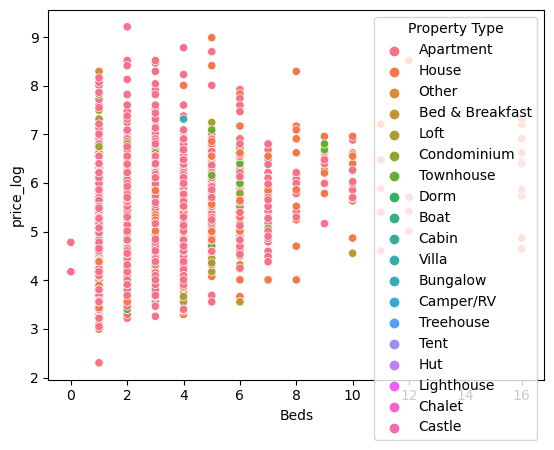

In [15]:
sns.scatterplot(data = df, x = 'Beds', y = 'price_log', hue = 'Property Type')
df.loc[:,['Property Type','Price']].groupby('Property Type').describe()

with the colors in place, for Room Type, it's more evident that both private and shared room rentals tend to be cheaper than renting an entire property, which makes sense logically. based on the description computations, on average, the room type with highest prices tend to be Entire home/apt and for property type, it's Villas and Condos that tend to have the highest rental prices on average (this is excluding the "Other" variable) with Lofts shortly behind. For room type, Entire home/apt has the highest std and for property type (excluding Other), Villa has the highest std.

Because there are outliers that skew the data, the median is a better, more reliable measure of central tendency because it doesn't take into account the actual values of the data points which skew the true average. The median just looks for the middle point of data if all points were from least to greatest. It doesn't matter if there's far outliers because they aren't accounted for when computing the median, which will show a more accurate representation of what the central tendancy is.

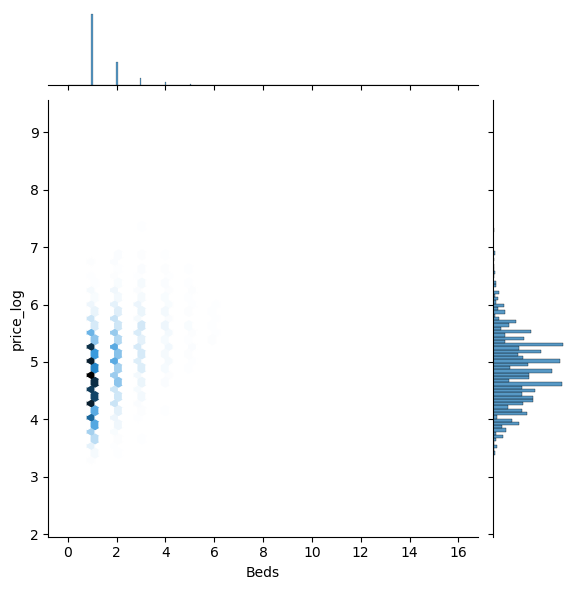

In [16]:
# q2.7 #

sns.jointplot(data = df, x = 'Beds', y = 'price_log', kind = 'hex')

# the jointplot shows that a majority of the data lies around 1-3 beds with the heaviest density around 1 bed being rented.
# there's little to no rentals placed anything greater than 6 beds. With the majority at 1 or 2 beds, the price range is
# roughly from 3.5 to 6, with majority at 4.5, which is roughly in the $100-$200 price range

# this plot reframes how the plots in 5 and 6 are seen since you can clearly see an exact point at where the majority of
# the data lie here, whereas in the prior plots, it seemed more of a larger spread of how the data was distributed, when in
# reality, the majority of the data was at lower number of be rentals instead of varying from 1-6

**Q4.** Go to https://data.cms.gov/search.
1. Pick a dataset about something you are interested in. Download the data and data dictionary. If you really can't decide, you can always use this one: https://data.cms.gov/medicare-current-beneficiary-survey-mcbs/medicare-current-beneficiary-survey-data
3. Does the data dictionary document how missings are handled? For categorical variables, does it describe the possible values and missing value codes? For the numeric variables, does it describe how missing values are handled? Summarize your opinion of the data dictionary.
4. Pick out a few interesting variables, and explain why you find them jointly interesting. Clean those variables, documenting your choices by commenting in the code or in a markdown chunk in a notebook.
5. For the variables you select, make a boxplot for each numeric variable and a bar graph for each categorical variable. Do you see any outliers?
6. Create a histogram or kernel density plot, and explain what you see. Do the results require any transformations to rescale them? 
7. Create a scatter plot, and describe the relationship you see.
8. Create a table (cross tabulation, variance-covariance, or a `.describe()` five-number summary), and explain what you see.

q4.2

There was a folder for codebooks and in the Fall one (because I'm using the Fall dataset), it doesn't explicitly say how missing values are handled, just that there's a code that corresponds to missing values. In the FAQ page, the only thing it mentions about missings or "Not indicated"s is to be mindful of them when calculating estimates and comparing distributions.

Yes, for categorical values (such as Medicare status) it lists the possible values and missing value codes. Same response as before for numerical variables: it doesn't describe how missings are handled, just that for that cell it'd be marked as "Inapplicable/Missing", as opposed to a given metric like the amount of time a person had been taking meds for HBP.

I think the data dictionary is fine as is, like it gives you the information needed to translate the abbreviated column names and what values correspond to what codes. If anything, it could detail a bit more on the variables themselves. I'm just thinking about the Codebook for the other lab with criminal pretrial data, like that was a whole PDF of thorough explanations for each code and what each header is/is for, so information like that would've been good to have for this one to get fuller picture of what this data is.

In [17]:
# necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# q4.3 #

df = pd.read_csv('./data/sfpuf2021_1_fall.csv', low_memory=False)
df.head()

,PUF_ID,SURVEYYR,VERSION,ADM_H_MEDSTA,ADM_H_GHPSW,ADM_H_PDRS,ADM_OP_MDCD,ADM_DUAL_FLAG_YR,ADM_FFS_FLAG_YR,ADM_MA_FLAG_YR,...,PUFF091,PUFF092,PUFF093,PUFF094,PUFF095,PUFF096,PUFF097,PUFF098,PUFF099,PUFF100
0,21000003,2021,1,1,2,1.0,1,1,3,1,...,988.252590,5273.441518,1095.075758,1245.906455,6049.581125,994.556718,5490.385215,1264.822658,5632.555206,989.464837
1,21000004,2021,1,1,2,1.0,1,1,3,1,...,22599.768459,3574.297077,2905.632202,3011.695926,4283.873099,18154.868227,16722.373362,15553.879545,14193.033902,18737.870831
2,21000005,2021,1,1,2,1.0,1,1,3,1,...,3998.371708,3748.552103,574.146156,4082.909199,559.108837,571.423027,3550.951071,4554.459435,605.491265,612.180490
3,21000011,2021,1,1,2,1.0,1,1,3,1,...,5679.361042,982.382754,1046.200903,1103.813758,1085.475033,1231.049575,1157.845607,720.394183,1134.894480,778.578574
4,21000012,2021,1,1,1,1.0,2,3,1,3,...,12188.282713,14418.230488,10457.419141,2761.012141,2160.504248,2346.820214,2230.871858,17188.553558,12597.595445,13900.497117


In [19]:
newtab = df[['DEM_AGE', 'DEM_SEX', 'DEM_RACE', 'HLT_OCHBP', 
            'HLT_OCBETES', 'HLT_OCCANCER', 'HLT_OCDEPRSS', 'RSK_SMKNOWAL', 
            ]]
newtab.head()

# why choose – first 4 are just good base metrics to have like demographic info;
# the others I think they're kinda in the same 'family' like cancer and smoking have a relationship, HBP and diabetes
# have a relationship, and for depression, that can kinda compare to a variety of diff vars like age, sex, etc
# made it into entirely new table for ease of use

,DEM_AGE,DEM_SEX,DEM_RACE,HLT_OCHBP,HLT_OCBETES,HLT_OCCANCER,HLT_OCDEPRSS,RSK_SMKNOWAL
0,3,2,1,1,2,2,2,2
1,2,1,2,1,1,2,2,2
2,3,2,1,2,2,2,2,2
3,3,2,1,2,2,1,2,2
4,2,2,3,2,1,2,1,2


In [20]:
# cleaning: renaming columns for better understanding to avg viewer who may not have this codebook handy

newtab.columns = ['Age', 'Sex', 'Race', 'High BP', 'Diabetes', 'Cancer', 'Depression', 'Smoker']
newtab.head()

,Age,Sex,Race,High BP,Diabetes,Cancer,Depression,Smoker
0,3,2,1,1,2,2,2,2
1,2,1,2,1,1,2,2,2
2,3,2,1,2,2,2,2,2
3,3,2,1,2,2,1,2,2
4,2,2,3,2,1,2,1,2


In [21]:
# cleaning each col: will omit the inapplicable/missing/unknown options bc they dont contribute anything
# meaningful for me

# newtab['High BP'].value_counts()

temp = newtab['High BP']
temp = temp.replace(['D', 'R'], np.nan)

newtab['High BP'] = temp
del temp

newtab['High BP'].value_counts()

/tmp/ipykernel_344400/2480741758.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtab['High BP'] = temp


High BP
1    8013
2    4736
Name: count, dtype: int64

In [22]:
# newtab['Diabetes'].value_counts()

temp = newtab['Diabetes']
temp = temp.replace(['D', 'R'], np.nan)

newtab['Diabetes'] = temp
del temp

newtab['Diabetes'].value_counts()

/tmp/ipykernel_344400/4090184593.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtab['Diabetes'] = temp


Diabetes
2    8775
1    3963
Name: count, dtype: int64

In [23]:
# newtab['Cancer'].value_counts()

temp = newtab['Cancer']
temp = temp.replace(['D', 'R'], np.nan)

newtab['Cancer'] = temp
del temp

newtab['Cancer'].value_counts()

/tmp/ipykernel_344400/1950047505.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtab['Cancer'] = temp


Cancer
2    10364
1     2394
Name: count, dtype: int64

In [24]:
# newtab['Depression'].value_counts()

temp = newtab['Depression']
temp = temp.replace(['D', 'R'], np.nan)

newtab['Depression'] = temp
del temp

newtab['Depression'].value_counts()

/tmp/ipykernel_344400/4168044164.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtab['Depression'] = temp


Depression
2    9313
1    3423
Name: count, dtype: int64

In [25]:
# newtab['Smoker'].value_counts()

temp = newtab['Smoker']
temp = temp.replace(['R'], np.nan)

newtab['Smoker'] = temp
del temp

newtab['Smoker'].value_counts()

/tmp/ipykernel_344400/3912536334.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newtab['Smoker'] = temp


Smoker
2    11407
1     1354
Name: count, dtype: int64

In [26]:
newtab.head()

,Age,Sex,Race,High BP,Diabetes,Cancer,Depression,Smoker
0,3,2,1,1,2,2,2,2
1,2,1,2,1,1,2,2,2
2,3,2,1,2,2,2,2,2
3,3,2,1,2,2,1,2,2
4,2,2,3,2,1,2,1,2


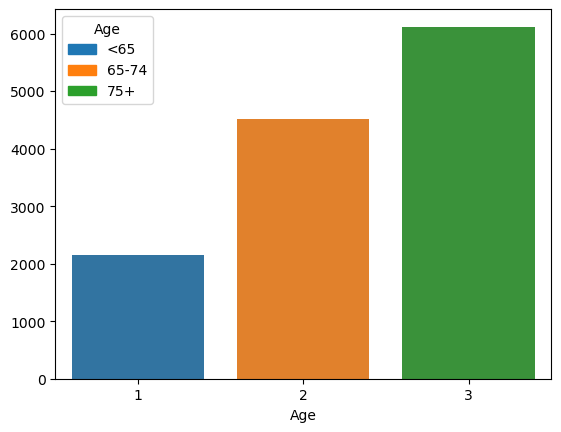

In [41]:
# q4.4 #

# newtab['Age'].value_counts()

# pls note i used ChatGPT to figure out how to plot the data that outputs from X.value_counts(), shown below:
age_counts = newtab['Age'].value_counts()
sns.barplot(x = age_counts.index, y = age_counts.values)

# pls note use of ChatGPT for aid in adding custom legend to graph to better illustrate what's being represented
# again bc some may not have the codebook on hand, so they won't know what the codes map to
plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1"),
            plt.Rectangle((0,0),1,1, color = "C2")], ['<65', '65-74', '75+'], title = "Age", loc = 'upper left')

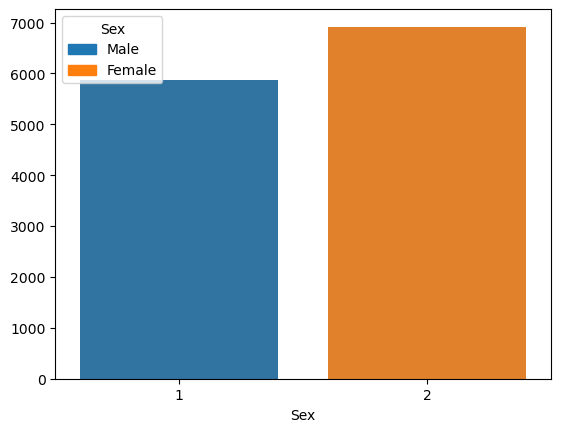

In [42]:
# newtab['Sex'].value_counts()

sex_counts = newtab['Sex'].value_counts()
sns.barplot(x = sex_counts.index, y = sex_counts.values)

# pls note use of ChatGPT for aid in adding custom legend to graph to better illustrate what's being represented
# again bc some may not have the codebook on hand, so they won't know what the codes map to
plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1")], ['Male', 'Female'], title = "Sex", loc = 'upper left')

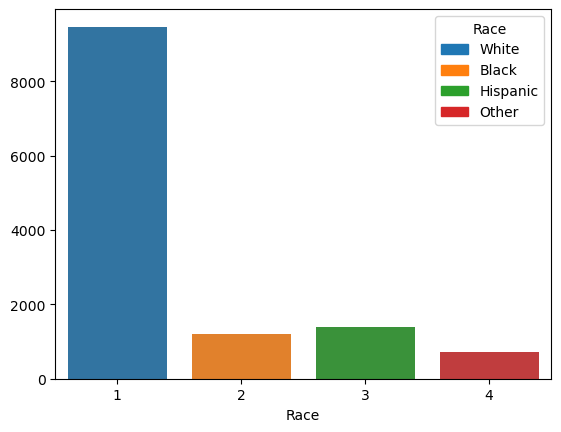

In [29]:
# newtab['Race'].value_counts()

race = newtab['Race'].value_counts()
sns.barplot(x = race.index, y = race.values)

plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1"),
            plt.Rectangle((0,0),1,1, color = "C2"),
            plt.Rectangle((0,0),1,1, color = "C3")], ['White', 'Black', 'Hispanic', 'Other'], title = "Race", loc = 'upper right')

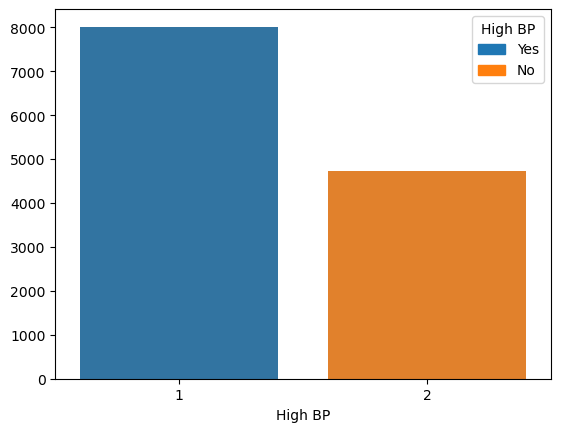

In [30]:
# newtab['High BP'].value_counts()

hbp = newtab['High BP'].value_counts()
sns.barplot(x = hbp.index, y = hbp.values)

plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1")], ['Yes', 'No'], title = "High BP")

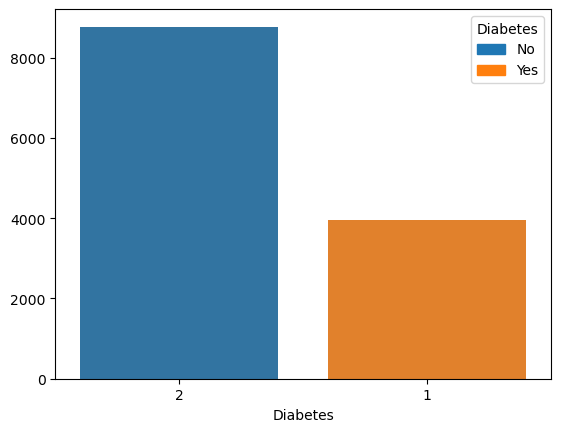

In [31]:
# newtab['Diabetes'].value_counts()

dbets = newtab['Diabetes'].value_counts()
sns.barplot(x = dbets.index, y = dbets.values)

plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1")], ['No', 'Yes'], title = "Diabetes")

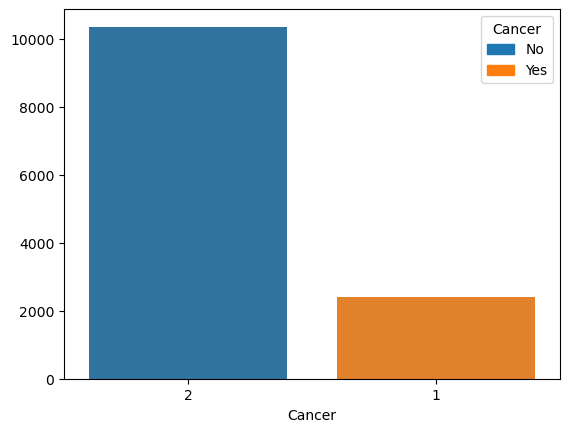

In [32]:
# newtab['Cancer'].value_counts()

can = newtab['Cancer'].value_counts()
sns.barplot(x = can.index, y = can.values)

plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1")], ['No', 'Yes'], title = "Cancer")

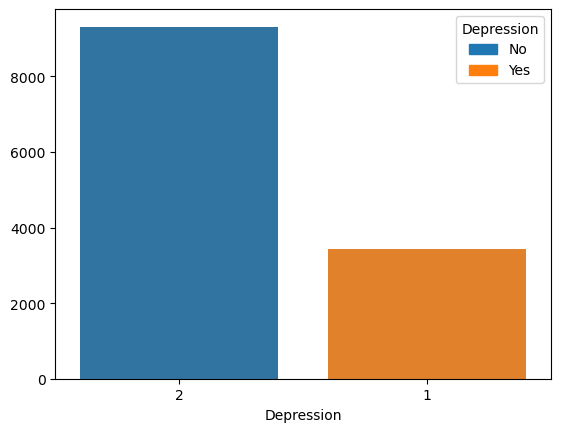

In [33]:
# newtab['Depression'].value_counts()

dep = newtab['Depression'].value_counts()
sns.barplot(x = dep.index, y = dep.values)

plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1")], ['No', 'Yes'], title = "Depression")

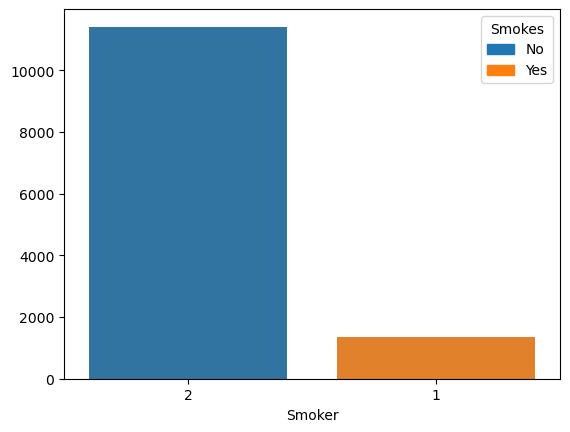

In [34]:
# newtab['Smoker'].value_counts()

smoke = newtab['Smoker'].value_counts()
sns.barplot(x = smoke.index, y = smoke.values)

plt.legend([plt.Rectangle((0,0),1,1, color = "C0"),
            plt.Rectangle((0,0),1,1, color = "C1")], ['No', 'Yes'], title = "Smokes")

I wouldn't really say there's outliers in the selected data, but I guess some noticeable things are that the number of respondants who were white significantly outnumbered that of any other race, even combined. There was also a very low metric in respondants who were <65 years of age, but that makes sense because of the general user type of people on Medicare. The yes/no metrics also showed pretty expected distributions where majority of respondants did not have the listed illness; conversely the only one where "Yes" outnumbered "No" was in having high blood pressure, but again, that's an expected metric with older individuals.

In [35]:
# q4.5 #

# sns.histplot(newtab['Age'])
# sns.histplot(newtab['Sex'])
# sns.kdeplot(newtab['Diabetes'])

I tested making both histograms and kde's, but given what the above 3 output, it's either the same thing as the above bar graphs from q4.4, or it won't work because numerical data is needed, but all the data from this dataset seem to be categorical whether it's a Yes/No response, a satisfaction scale, demographic selection, or other qualitative measurements to record. I'm not quite sure how else to approach this question if the data is all categorical. In a theoretical dataset that had numerical data to plot, there would really only be need of transformation/scaling if the data was incredibly skewed left or right, making it harder to interpret the results, as evidenced in q2. 

<Axes: xlabel='Age', ylabel='Density'>

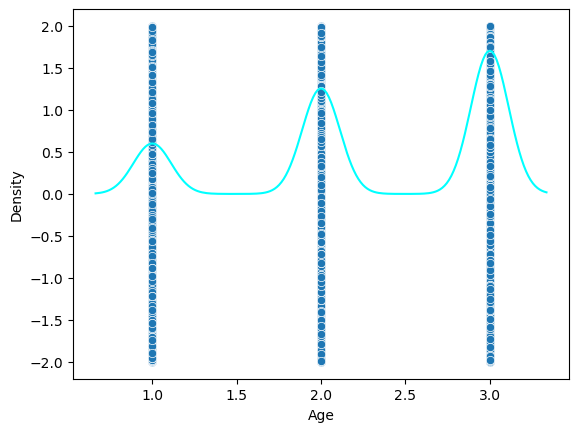

In [36]:
# q4.6 #

# bc the data I have is categorical, a scatterplot on its own would not really show much... went to ChatGPT to try and figure
# out how to show these data points while also showing the general distribution and that entailed of jittering the data and
# displaying as uniform distribution with a kdeplot overlayed to show the trend of where respondants lie

x = newtab['Age'] 
y = np.random.uniform(-2, 2, size=len(x)) # this line obtained from CGPT

sns.scatterplot(x = x, y = y)
sns.kdeplot(x = x, color = 'cyan')

# trend is that as age range increased, so did the number of respondants reporting that age range

<Axes: xlabel='Age', ylabel='Race'>

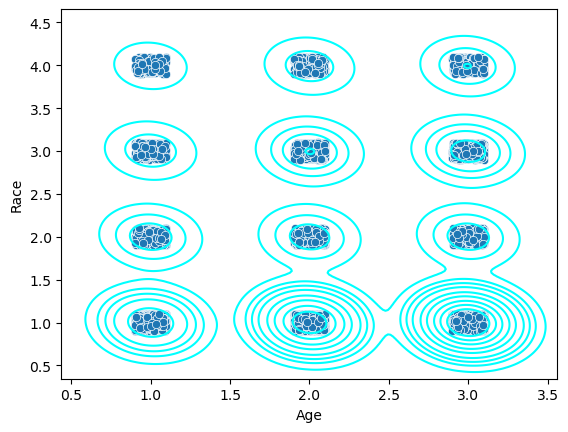

In [67]:
x = newtab['Age'] + np.random.uniform(-0.1, 0.1, size=len(newtab))
y = newtab['Race'] + np.random.uniform(-0.1, 0.1, size=len(newtab))

sns.scatterplot(x = x, y = y)
sns.kdeplot(x = x, y = y, color = 'cyan')

# this graph kind of just happened on accident as result of experimenting with stuff to graph, and I was gonna delete it bc of
# how bizarre it looked, but I kept it in bc it reminded me of those topography maps – you can clearly see a high density 
# in Age code 3, Race code 1 given all the concentric circles from the kde plot surrounding the clustered points, thus indicating
# a large amount of respondants corresponding to A3:R1 or respondants who are White and above the age of 75.

# conversely, there is little to no density surrounding Age 1, Race 4, which corresponds to individuals younger than 65 and
# those who are not White, Black, nor Hispanic – this plot shares information on the general demographic of respondants,
# indicating that, out of the surveyed population, older + white individuals were the majority of responders for the Medicare
# beneficiary survey

In [45]:
# q4.7 # 

pd.crosstab(newtab['Cancer'], newtab['Smoker'])

Smoker,1,2
Cancer,,
1,239,2155
2,1114,9238


This data shows that there's not a solid relationship between having cancer and being a smoker, which was surprising to me. I think if there was a specific category of "lung cancer" like there is for skin cancer (HLT_OCCSKIN), then that data could show more promising results when compared to being a smoker since the two are more closely related. Cancer of any type is too broad to have shown a strong relationship to smoking, as shown by the table.

In [39]:
pd.crosstab(newtab['High BP'], newtab['Diabetes'])

Diabetes,1,2
High BP,,
1,3092,4908
2,862,3856


The above table shows that a majority of respondants report having high bp and no sign of diabetes, or neither stat; however, there was still a good number of respondants reporting of having both high bp and diabetes, which could indicate a possible correlation between the two metrics, but it is inconclusive to state that one causes the other.

In [40]:
pd.crosstab(newtab['Race'], newtab['High BP'])

High BP,1,2
Race,,
1,5722,3721
2,907,300
3,916,476
4,468,239


In [43]:
pd.crosstab(newtab['Age'], newtab['High BP'])

High BP,1,2
Age,,
1,1031,1114
2,2683,1817
3,4299,1805


For these last 2 crosstabs, it seems that regardless of race, respondants generally reported having a high bp, especially those who were older. In comparing age and high bp, the trend was for the most part the same, with more older respondants reporting having a high bp. For the range of respondants under the age of 65, more respondants reported *not* having a high bp.